# **Case**

The transactional data for a retail store selling books, gifts & stationery over a 15 year period with details of over 18000+ customers. The data contains the customer_ID,date of purchase and the total_amount

The goal was the find segments of customers based on their buying behaviour so that the store could offer targetted engagement strategies to drive sales

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [87]:
# Load the data
df = pd.read_csv("/content/drive/MyDrive/Projects/RFM Analysis/purchases.txt", sep='\t', header=None, names=['customer_id', 'purchase_amount', 'date_of_purchase'])
df['date_of_purchase'] = pd.to_datetime(df['date_of_purchase'])
df['days_since'] = (pd.to_datetime("2016-01-01") - df['date_of_purchase']).dt.days

# **RFM Analysis**

A technique by which customers are segmented basis the variable of recency, frequency and monetary value

Recency-Days elapsed since last visit
Frequency- Number Of Visits per year
Monetary Value- The Average Order Value

These values are calculated for each particular customer

In [88]:
# Compute RFM
rfm = df.groupby('customer_id').agg(
    recency=('days_since', 'min'),
    frequency=('customer_id', 'count'),
    amount=('purchase_amount', 'mean')
)
print(rfm.head())


             recency  frequency      amount
customer_id                                
10              3829          1   30.000000
80               343          7   71.428571
90               758         10  115.800000
120             1401          1   20.000000
130             2970          2   50.000000


# **EDA**

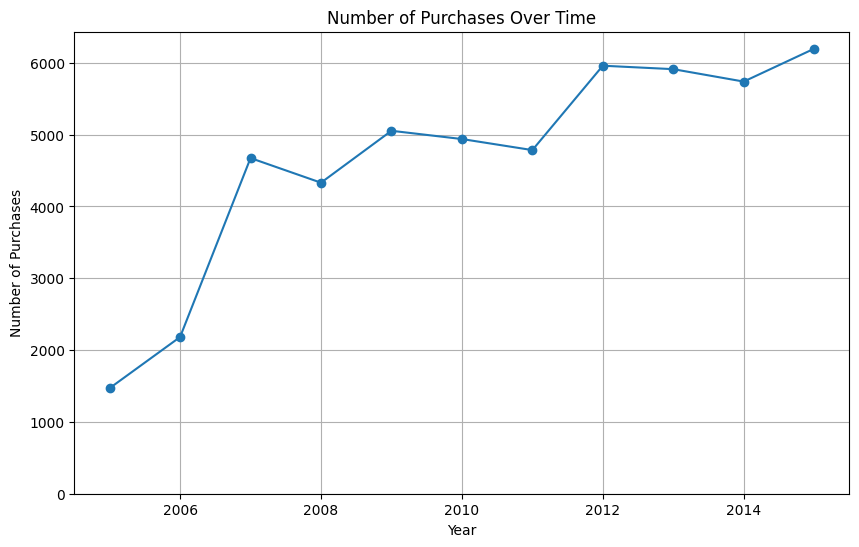

In [89]:
import matplotlib.pyplot as plt
# Extract year from 'date_of_purchase'
df['year'] = df['date_of_purchase'].dt.year

# Group by year and count the number of purchases
purchases_by_year = df.groupby('year').size().reset_index(name='number_of_purchases')

# Plot the number of purchases by year
plt.figure(figsize=(10, 6))
plt.plot(purchases_by_year['year'], purchases_by_year['number_of_purchases'], marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Purchases')
plt.title('Number of Purchases Over Time')
plt.grid(True)
plt.ylim(bottom=0)
plt.show()


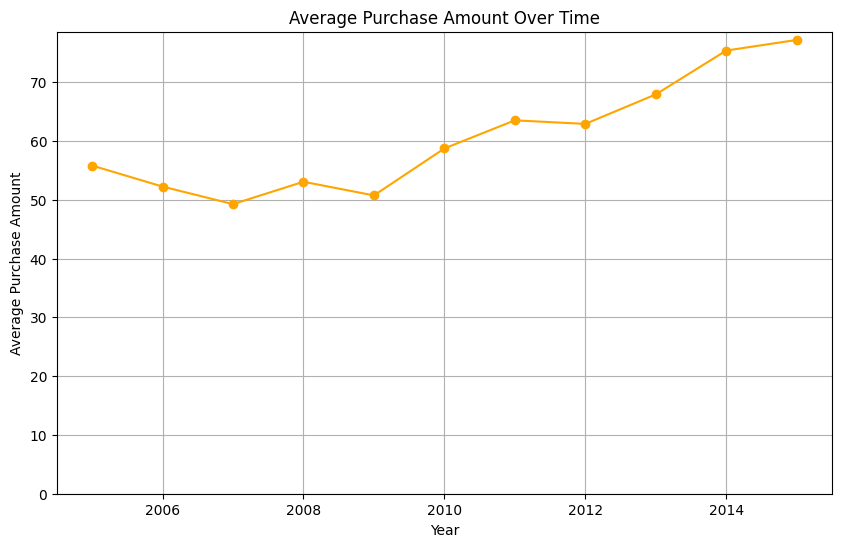

In [90]:
# Calculate the average purchase amount per year
average_amount_by_year = df.groupby('year')['purchase_amount'].mean().reset_index(name='average_purchase_amount')

# Plot the average purchase amount by year
plt.figure(figsize=(10, 6))
plt.plot(average_amount_by_year['year'], average_amount_by_year['average_purchase_amount'], marker='o', color='orange')
plt.xlabel('Year')
plt.ylabel('Average Purchase Amount')
plt.title('Average Purchase Amount Over Time')
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

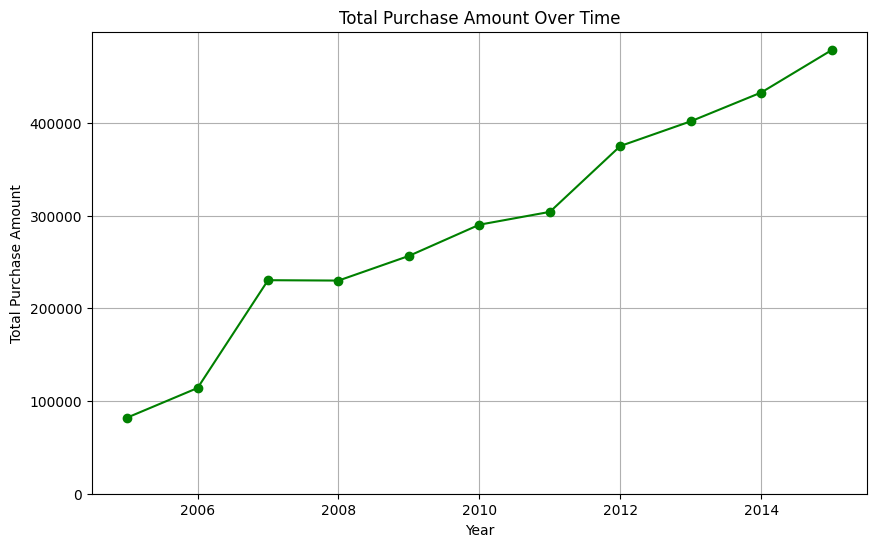

In [91]:
import matplotlib.pyplot as plt
# Group by year and sum the purchase amount
amount_by_year = df.groupby('year')['purchase_amount'].sum().reset_index(name='total_purchase_amount')

# Plot the total purchase amount by year
plt.figure(figsize=(10, 6))
plt.plot(amount_by_year['year'], amount_by_year['total_purchase_amount'], marker='o', color='green')
plt.xlabel('Year')
plt.ylabel('Total Purchase Amount')
plt.title('Total Purchase Amount Over Time')
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

**Increase in avg billvalue but stagnating no of transactions**

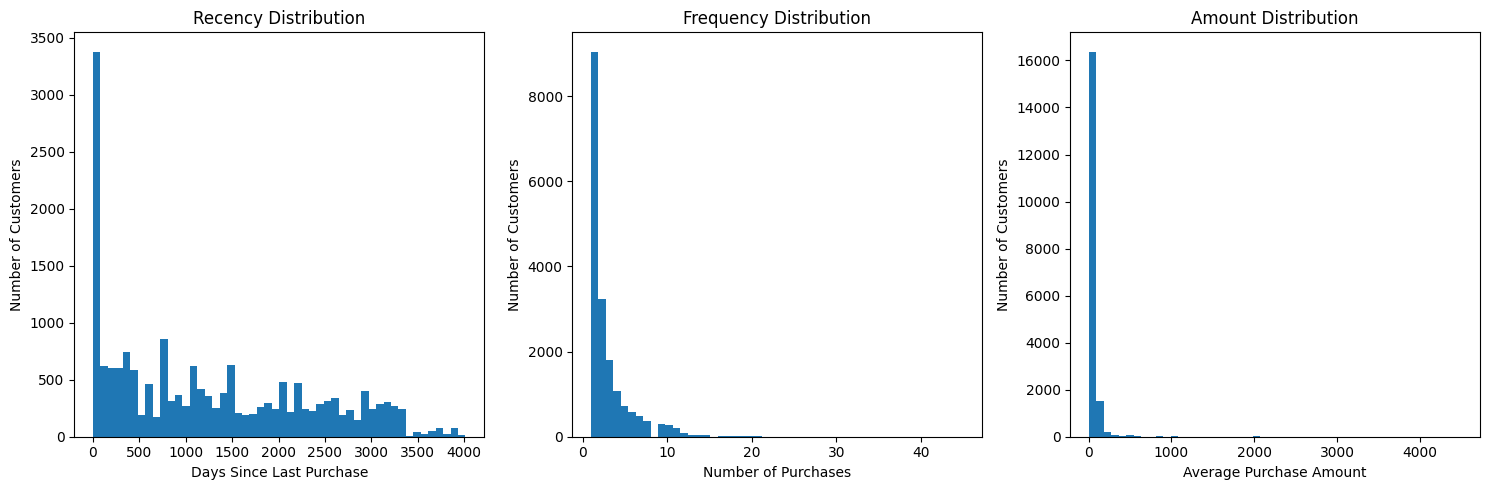

In [92]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(rfm['recency'], bins=50)
plt.title('Recency Distribution')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Number of Customers')

plt.subplot(1, 3, 2)
plt.hist(rfm['frequency'], bins=50)
plt.title('Frequency Distribution')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Customers')

plt.subplot(1, 3, 3)
plt.hist(rfm['amount'], bins=50)
plt.title('Amount Distribution')
plt.xlabel('Average Purchase Amount')
plt.ylabel('Number of Customers')

plt.tight_layout()
plt.show()


**Recency**: Right skewed distribution with a chunk of customers who made their last purchase 100 days back with a long tail

**Number Of Purchases**: Right skewed with a large number of customers having lifetime sales of 1 or 2

**Average Purchase Amount**:Extremely right skewed with most of the customers having a AOV of less than 100

# **Summary Stats**

In [93]:
print("\nAverage Recency:", rfm['recency'].mean())
print("Average Frequency:", rfm['frequency'].mean())
print("Average Amount:", rfm['amount'].mean())


Average Recency: 1253.03789976652
Average Frequency: 2.7823749796383774
Average Amount: 57.79298510181561


# **Carrying Out a log transformation to normalise the highly skewed amount column**

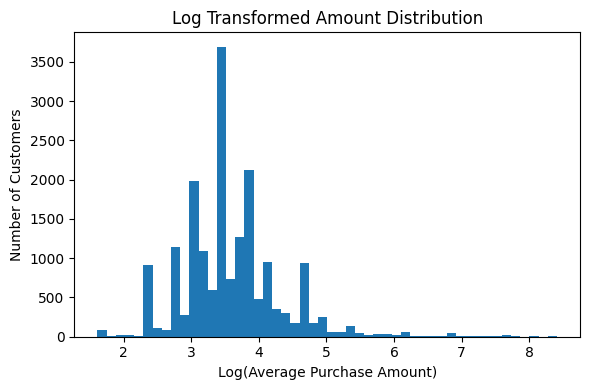

In [94]:
import matplotlib.pyplot as plt
import numpy as np
# Log transform 'amount' and add a small constant to handle zero values before log transformation
rfm['log_amount'] = np.log(rfm['amount'] + 1e-9)

# Plot the histogram of the log-transformed 'amount'
plt.figure(figsize=(6, 4))
plt.hist(rfm['log_amount'], bins=50)
plt.title('Log Transformed Amount Distribution')
plt.xlabel('Log(Average Purchase Amount)')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()




# **Scaling the features**

All features are scaled using the standard scaler so as to ensure no variable has a dominating effect while doing k-means clustering

In [95]:
# Select the RFM variables for scaling
rfm_data = rfm[['recency', 'frequency', 'log_amount']]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
rfm_scaled = scaler.fit_transform(rfm_data)

# Convert the scaled data back to a DataFrame
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['recency', 'frequency', 'log_amount'], index=rfm.index)

print(rfm_scaled_df.head())

              recency  frequency  log_amount
customer_id                                 
10           2.382043  -0.606909   -0.235802
80          -0.841530   1.436125    0.894386
90          -0.457771   2.457642    1.523861
120          0.136824  -0.606909   -0.764046
130          1.587709  -0.266403    0.429707


# **Finding optimal Number Of Clusters- K-Means Clustering**

The customer segmentaion was done using k-means clustering an unsupervised ML model Since K-Means Clustering requires number of clusters to be defined beforehand the optimal number of clusters have to be determined

This was done using the elbow method

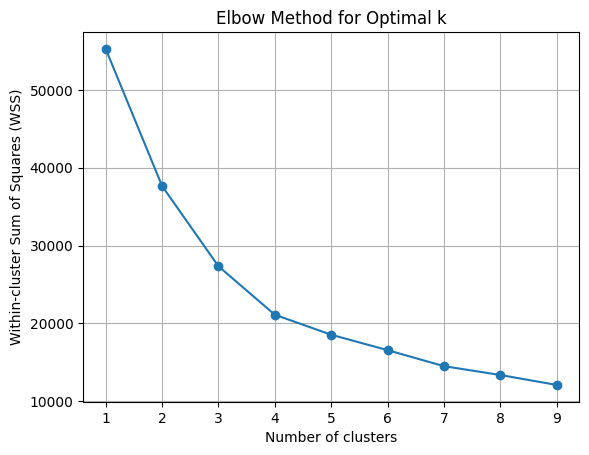

In [96]:
# Elbow Method to determine optimal k
wss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=123)
    kmeans.fit(rfm_scaled)
    wss.append(kmeans.inertia_)

plt.plot(range(1, 10), wss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares (WSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

Optimal Number of clusters is where Within Cluster Sum of Squares(WCSS) is least, After 6 it stagnates and thee is not much reduction of this parameter beyond this

In [97]:
# Apply KMeans with 6 clusters
kmeans_final = KMeans(n_clusters=6, random_state=123)
rfm['cluster'] = kmeans_final.fit_predict(rfm_scaled)

# Cluster-wise averages
cluster_summary = rfm.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'amount': 'mean'
}).round(2)

cluster_summary['num_customers'] = rfm['cluster'].value_counts()
cluster_summary

print(cluster_summary)


         recency  frequency  amount  num_customers
cluster                                           
0         728.25       1.67   23.47           4893
1        2619.89       1.49   31.11           5671
2         217.31      12.19   63.43            860
3        1001.19       3.00  495.39            725
4         705.49       1.84   66.35           3873
5         422.28       6.21   42.75           2395


The average values of each of the variables Recency, Frequqncy and Monetary Value for each particular segment  was then determined.

Customers falling into each of these cluters show different buying behaviour as is reflected by the values

**"Normal" or "Good" Values For Recency, Frequency, Amount**


The "normal" values of each of these variables would be decided given the particular case to case basis. For example the accepted normal for recency would vary significantly between a clothes retailer and grocceries retailer


In this case since it is a gift shop which people do not usually visit so often

# **Segments Buying Behaviour Analysis**


 **Cluster 0** :

Customers who visit on average once in 2 years, on average visit the store twice spending an average amount of 23 Rs

Less engaged have to be won back, on the verge of churning


 **Cluster 1** :

Customers who visit on average once in 8-9 years, on average visit the store once spending an average amount of 31 Rs

Churned out most likely, may have been vistors who just dropped in. Not important


 **Cluster 2** :

Customers who visit on average once in less than 1 year time, on average visit the store 12 times(lifetime visits) spending an average amount of 63 Rs

Loyal customers


 **Cluster 3** :

 Customers who visit on average once in 8-9 years, on average visit the store thrice  spending an average amount of 459 Rs

Similar to cluster 1, mostly churned out, very spaced out visits but spend high amounts


**Cluster 4** :

Customers who visit on average once in 2 years, on average visit the store twice spending an average amount of 66 Rs

Less engaged have to be won back, on the verge of churning, simialr to cluster 0


**Cluster 5** :

Customers who visit on average once in 1 years, on average visit the store 6 times(Life time) spending an average amount of 42 Rs

Engaged users










# **Identifying the most valuable segments**

In [98]:
cluster_summary['lifetime_revenue'] = cluster_summary['frequency'] * cluster_summary['amount']
print(cluster_summary)

         recency  frequency  amount  num_customers  lifetime_revenue
cluster                                                             
0         728.25       1.67   23.47           4893           39.1949
1        2619.89       1.49   31.11           5671           46.3539
2         217.31      12.19   63.43            860          773.2117
3        1001.19       3.00  495.39            725         1486.1700
4         705.49       1.84   66.35           3873          122.0840
5         422.28       6.21   42.75           2395          265.4775


**Cluster 3** has the highest average lifetime revenue (₹1486) and also the highest transaction amount, though with moderate visit frequency. These are likely high-ticket but infrequent buyers — a valuable but niche segment.

**Cluster 2** shows the second highest lifetime revenue (₹773) and the highest frequency (12.19), indicating highly engaged loyal customers who contribute significantly over time. They account for ~5% of the base but are crucial for long-term value.

**Cluster 5** has the third highest lifetime revenue and strong engagement. There’s potential to increase their transaction size with cross-sells or personalized offers.

# **Conclusion and Recommendations**

* **Cluster 3** : Target with premium offerings or exclusive experiences. Their high spend makes them ideal for limited, high-value campaigns. However, large-scale marketing may not be ROI-positive due to moderate frequency.

* **Cluster 2** : This is your core loyal segment. Prioritize retention, loyalty programs, and tailored promotions. Also ideal for upsell/cross-sell initiatives.

* **Cluster 5** : Focus on increasing their transaction size or frequency via reminders, new product launches, or combo offers.

* **Cluster 0 and 4** : These are disengaged or dropping-off customers. Win-back strategies such as reactivation discounts or feedback loops may help revive interest.

* **Cluster 1** : These are highly dormant users with the lowest revenue. Resources may be better spent elsewhere unless you identify niche potential or misclassification.
